In [1]:
# -*- coding: utf-8 -*-
"""
Created on 2022

@author: S.W
"""

'\nCreated on 2022\n\n@author: S.W\n'

# 1. 학습에 필요한 라이브러리 import

In [2]:
import os
import PIL
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

# 2. CIFAR10 데이터셋 불러오기

In [3]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# class : airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()


In [4]:
from keras.utils import np_utils

# one-hot encoding
train_labels = np_utils.to_categorical(train_labels, 10)
test_labels = np_utils.to_categorical(test_labels, 10)

train_labels[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [5]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [6]:
X = np.concatenate([train_images, test_images])
y = np.concatenate([train_labels, test_labels])
print(np.concatenate([train_images, test_images]).shape)
print(np.concatenate([train_labels, test_labels]).shape)

(60000, 32, 32, 3)
(60000, 10)


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

train_set_X, test_set_X, train_set_y, test_set_y = train_test_split(X, y,
                                                    test_size=0.02,
                                                    train_size=0.1, random_state=42)

In [8]:
train_set_X.shape, test_set_X.shape, train_set_y.shape, test_set_y.shape

((6000, 32, 32, 3), (1200, 32, 32, 3), (6000, 10), (1200, 10))

In [9]:
np.sum(train_set_y, axis=0) , np.sum(test_set_y, axis=0)

(array([627., 569., 599., 629., 567., 585., 570., 623., 635., 596.],
       dtype=float32),
 array([109., 134., 118., 131., 116., 132., 112., 131.,  98., 119.],
       dtype=float32))

AxesImage(80,52.8;496x369.6)
숫자:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


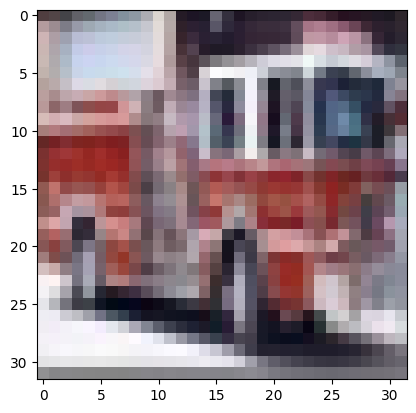

In [10]:
n = 200
print(plt.imshow(train_set_X[n]))
print("숫자: ",train_set_y[n])

# 3.Pre-Trained Model 불러오기

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

# model = VGG16(input_shape=(32, 32, 3), include_top=False, weights=None)
model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
# include_top : FC layer를 포함할지 안할지
# weight : None or "imagenet"
# input_shape : input tensor shape control

model.trainable =True # 모델의 가중치를 열어놓는 코드

model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [12]:
model.get_layer('block4_conv3')

In [13]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

output = model.get_layer('block2_pool').output # 모델의 가장 마지막 층 반환

# VGG16 모델 위에 신경망 쌓기
x = GlobalAveragePooling2D()(output)
x = Dense(500, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='sigmoid', name='output')(x)
    
transfer_model = Model(inputs=model.input, outputs=output)
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [14]:
# ImageDataGenerator를 통해 학습 데이터 Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

train_gen = ImageDataGenerator(
#     horizontal_flip=True,
    rescale=1/255.0
)

# 검증용 데이터 세트는 scale만 바꾸어주고 augmentation 적용하면 안됨
test_gen = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_gen.flow(train_set_X, train_set_y, batch_size=64, shuffle=True)
flow_test_gen = test_gen.flow(test_set_X, test_set_y, batch_size=64, shuffle=False)

# 4. 모델 학습

In [15]:
transfer_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = transfer_model.fit(flow_tr_gen, epochs=50, validation_data=flow_test_gen)

Epoch 1/50
94/94 [==============================] - 3s 12ms/step - loss: 2.4035 - accuracy: 0.1857 - val_loss: 1.9257 - val_accuracy: 0.2967
Epoch 2/50
94/94 [==============================] - 1s 8ms/step - loss: 1.8225 - accuracy: 0.3078 - val_loss: 1.7177 - val_accuracy: 0.3592
Epoch 3/50
94/94 [==============================] - 1s 8ms/step - loss: 1.6360 - accuracy: 0.4032 - val_loss: 1.4853 - val_accuracy: 0.4383
Epoch 4/50
94/94 [==============================] - 1s 8ms/step - loss: 1.5210 - accuracy: 0.4445 - val_loss: 1.4237 - val_accuracy: 0.4925
Epoch 5/50
94/94 [==============================] - 1s 8ms/step - loss: 1.3812 - accuracy: 0.4993 - val_loss: 1.2487 - val_accuracy: 0.5408
Epoch 6/50
94/94 [==============================] - 1s 8ms/step - loss: 1.2733 - accuracy: 0.5360 - val_loss: 1.3135 - val_accuracy: 0.5108
Epoch 7/50
94/94 [==============================] - 1s 8ms/step - loss: 1.2038 - accuracy: 0.5643 - val_loss: 1.2583 - val_accuracy: 0.5558
Epoch 8/50
94/94 [=

19/19 [==============================] - 0s 3ms/step - loss: 1.7308 - accuracy: 0.6658

Accuracy: 0.6658


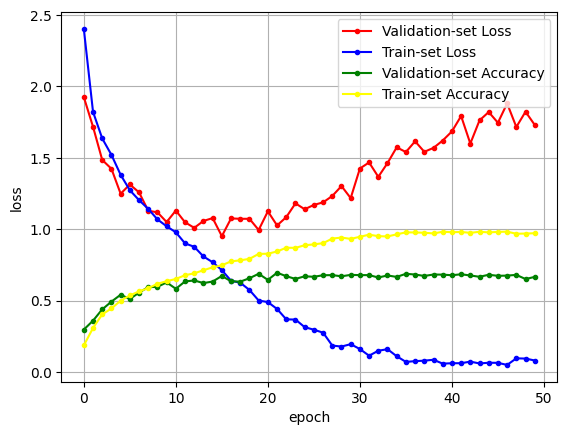

In [16]:
# 출처
# https://snowdeer.github.io/machine-learning/2018/01/10/check-relation-between-epoch-and-loss-using-graph/

print('\nAccuracy: {:.4f}'.format(transfer_model.evaluate(flow_test_gen)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vacc, marker='.', c='green', label="Validation-set Accuracy")
plt.plot(x_len, y_acc, marker='.', c='yellow', label="Train-set Accuracy")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# plt.legend(loc='upper left')
# plt.grid()
# plt.xlabel('epoch')
# plt.ylabel('Accuracy')
# plt.show()

In [17]:
# 모델 테스트 데이터 예측값 출력
y_pred = transfer_model.predict(flow_test_gen)
y_pred

array([[9.9957067e-01, 9.9965811e-01, 8.0781312e-08, ..., 6.8972246e-09,
        9.9940622e-01, 9.9994159e-01],
       [6.0472368e-05, 9.9770290e-01, 1.1234814e-07, ..., 3.9153907e-05,
        9.9986625e-01, 9.9999344e-01],
       [7.3166839e-06, 7.7029364e-07, 7.8967530e-01, ..., 2.3737010e-04,
        7.1551773e-04, 1.4468581e-04],
       ...,
       [1.4680351e-02, 7.6720822e-01, 2.8437213e-07, ..., 1.5462765e-08,
        9.9999976e-01, 9.9942732e-01],
       [1.1034013e-03, 1.1942617e-05, 9.9998558e-01, ..., 9.9897802e-01,
        7.9225060e-08, 1.2986818e-09],
       [9.9774522e-01, 7.9906978e-02, 1.0247714e-01, ..., 1.5554841e-05,
        8.7232268e-01, 7.4980268e-03]], dtype=float32)

In [18]:
# 열 단위, 가장 높은 값을 반환

np.argmax(test_set_y, axis=1) # ground truth
np.argmax(y_pred, axis=1)     # predict

array([9, 9, 4, ..., 8, 2, 0], dtype=int64)

# 5. 모델 평가

In [19]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(test_set_y, axis=1), np.argmax(y_pred, axis=1))

0.6633333333333333

# 6. Data Augmentation을 통한 성능 개선

In [20]:
train_gen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    fill_mode='nearest',
    rescale=1/255.0
)

# 검증용 데이터 세트는 scale만 바꾸어주고 augmentation 적용하면 안됨
test_gen = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_gen.flow(train_set_X, train_set_y, batch_size=64, shuffle=True)
flow_test_gen = test_gen.flow(test_set_X, test_set_y, batch_size=64, shuffle=False)

In [21]:
# model = VGG16(input_shape=(32, 32, 3), include_top=False, weights=None)
model = VGG16(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
# include_top : FC layer를 포함할지 안할지
# weight : None or "imagenet"
# input_shape : input tensor shape control

model.trainable =True # 모델의 가중치를 열어놓는 코드

output = model.get_layer('block2_pool').output # 모델의 가장 마지막 층 반환

# VGG16 모델 위에 신경망 쌓기
x = GlobalAveragePooling2D()(output)
x = Dense(500, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='sigmoid', name='output')(x)
    
transfer_model = Model(inputs=model.input, outputs=output)

transfer_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [22]:
transfer_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = transfer_model.fit(flow_tr_gen, epochs=50, validation_data=flow_test_gen)

Epoch 1/50
94/94 [==============================] - 1s 11ms/step - loss: 2.4805 - accuracy: 0.1723 - val_loss: 1.9048 - val_accuracy: 0.2458
Epoch 2/50
94/94 [==============================] - 1s 10ms/step - loss: 1.9138 - accuracy: 0.2672 - val_loss: 1.6939 - val_accuracy: 0.3758
Epoch 3/50
94/94 [==============================] - 1s 10ms/step - loss: 1.7214 - accuracy: 0.3565 - val_loss: 1.5658 - val_accuracy: 0.4317
Epoch 4/50
94/94 [==============================] - 1s 10ms/step - loss: 1.5992 - accuracy: 0.4057 - val_loss: 1.4624 - val_accuracy: 0.4783
Epoch 5/50
94/94 [==============================] - 1s 10ms/step - loss: 1.4885 - accuracy: 0.4565 - val_loss: 1.3610 - val_accuracy: 0.4767
Epoch 6/50
94/94 [==============================] - 1s 10ms/step - loss: 1.4122 - accuracy: 0.4893 - val_loss: 1.2776 - val_accuracy: 0.5425
Epoch 7/50
94/94 [==============================] - 1s 11ms/step - loss: 1.3374 - accuracy: 0.5200 - val_loss: 1.2310 - val_accuracy: 0.5508
Epoch 8/50
94

19/19 [==============================] - 0s 3ms/step - loss: 0.9341 - accuracy: 0.7067

Accuracy: 0.7067


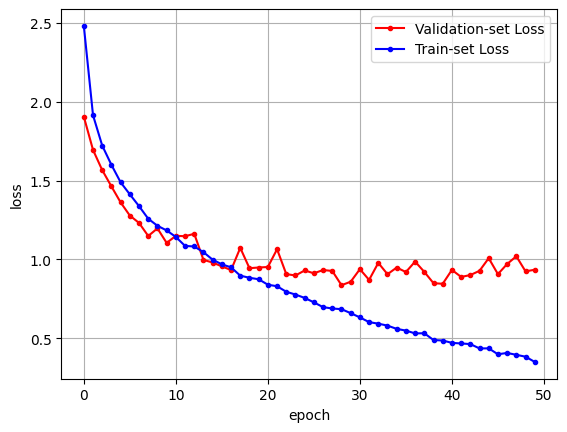

In [23]:
# 출처
# https://snowdeer.github.io/machine-learning/2018/01/10/check-relation-between-epoch-and-loss-using-graph/

print('\nAccuracy: {:.4f}'.format(transfer_model.evaluate(flow_test_gen)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [24]:
# 모델 테스트 데이터 예측값 출력
y_pred = transfer_model.predict(flow_test_gen)
y_pred

array([[9.9744594e-01, 9.9999821e-01, 1.1469305e-04, ..., 6.7334645e-07,
        1.9013345e-01, 9.9917740e-01],
       [8.0025661e-01, 9.8456532e-01, 2.2420357e-04, ..., 1.1962472e-02,
        9.6223897e-01, 9.9598002e-01],
       [9.3516707e-04, 2.3395530e-04, 7.5164235e-01, ..., 6.3466090e-03,
        5.7349092e-04, 8.9920475e-05],
       ...,
       [7.0514792e-01, 9.9739045e-01, 1.4131131e-05, ..., 2.3495890e-07,
        9.9917066e-01, 8.1481481e-01],
       [7.9413265e-01, 1.0956874e-05, 9.9949551e-01, ..., 9.9766481e-01,
        3.8414535e-07, 5.1676432e-07],
       [9.9942040e-01, 5.9373909e-01, 1.6611102e-01, ..., 2.3334825e-03,
        2.9610714e-01, 6.8201390e-03]], dtype=float32)

In [25]:
# 열 단위, 가장 높은 값을 반환

# np.argmax(test_set_y, axis=1) # ground truth
# np.argmax(y_pred, axis=1)     # predict

In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(test_set_y, axis=1), np.argmax(y_pred, axis=1))

0.7066666666666667